In [ ]:
data_dir = '/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'



import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since we're going to be generating faces, we won't need the annotations.  We can view the first number of examples by changing `show_n_images`.

In [ ]:
show_n_images = 25


mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
We'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`



In [ ]:

from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [ ]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    

    inputs_real=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='inputs_real')
    inputs_z=tf.placeholder(tf.float32,(None,z_dim),name='inputs_z')
    lr=tf.placeholder(tf.float32,name='lr')
    
    return inputs_real,inputs_z,lr



tests.test_model_inputs(model_inputs)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network. We Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [ ]:
def discriminator(images, reuse=False,alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        relu1=tf.layers.dropout(relu1,rate=0.3)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2=tf.layers.dropout(relu2,rate=0.3)
        # 7x7x128
        
        

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1,kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        
    return out, logits



tests.test_discriminator(discriminator, tf)

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network. We Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [ ]:
def generator(z, out_channel_dim,is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*128,kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1=tf.layers.dropout(x1,rate=0.3)
        # 7x7x128 now
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2=tf.layers.dropout(x2,rate=0.3)
        # 14x14x64 now
        
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
    return out


tests.test_generator(generator, tf)

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss). We  Use the following functions we implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [ ]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=0.9*tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=0.9*tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    
    


tests.test_model_loss(model_loss)

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. We Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.We  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [ ]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



tests.test_model_opt(model_opt, tf)

## Neural Network Training
### Show Output
We Use this function to show the current output of the generator during training. It will help us determine how well the GANs is training.

In [ ]:

import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.We Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`



In [26]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    inputs_real,inputs_z,lr=model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    
    
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step=0
    losses=[]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                
                batch_images=batch_images*2
                step+=1
                batch_z=np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                _=sess.run(d_opt,feed_dict={inputs_real:batch_images,inputs_z:batch_z,lr:learning_rate})
                _=sess.run(g_opt,feed_dict={inputs_z:batch_z,inputs_real:batch_images,lr:learning_rate})
                if step%10==0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                if step % 100 == 0:
                    show_generator_output(sess, 25 , inputs_z, data_shape[3], data_image_mode) 
    return losses

### MNIST
We Test our GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  

In [42]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 0.6872... Generator Loss: 1.0560
Epoch 1/2... Discriminator Loss: 0.9221... Generator Loss: 0.9974
Epoch 1/2... Discriminator Loss: 1.1337... Generator Loss: 0.8482
Epoch 1/2... Discriminator Loss: 0.8994... Generator Loss: 2.1022
Epoch 1/2... Discriminator Loss: 0.7465... Generator Loss: 2.3753
Epoch 1/2... Discriminator Loss: 0.7328... Generator Loss: 1.0629
Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 0.7044
Epoch 1/2... Discriminator Loss: 0.7569... Generator Loss: 1.0820
Epoch 1/2... Discriminator Loss: 0.6718... Generator Loss: 1.5772
Epoch 1/2... Discriminator Loss: 0.6087... Generator Loss: 1.4131
Epoch 1/2... Discriminator Loss: 0.7715... Generator Loss: 1.9444
Epoch 1/2... Discriminator Loss: 0.5676... Generator Loss: 1.3470
Epoch 1/2... Discriminator Loss: 0.6016... Generator Loss: 1.5321
Epoch 1/2... Discriminator Loss: 0.7223... Generator Loss: 0.8772
Epoch 1/2... Discriminator Loss: 0.8047... Generator Loss: 0.8364
Epoch 1/2.

### CelebA
We Run our GANs on CelebA.  

Epoch 1/2... Discriminator Loss: 1.7808... Generator Loss: 0.3688
Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 0.7646
Epoch 1/2... Discriminator Loss: 0.9363... Generator Loss: 0.9714
Epoch 1/2... Discriminator Loss: 2.3333... Generator Loss: 0.1896
Epoch 1/2... Discriminator Loss: 1.6343... Generator Loss: 0.3856
Epoch 1/2... Discriminator Loss: 1.4239... Generator Loss: 2.1745
Epoch 1/2... Discriminator Loss: 1.4012... Generator Loss: 0.5436
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 0.9444
Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 0.5724
Epoch 1/2... Discriminator Loss: 1.7434... Generator Loss: 0.3577


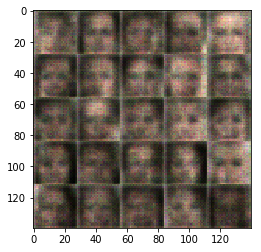

Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 1.4578
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.5204
Epoch 1/2... Discriminator Loss: 2.5455... Generator Loss: 0.1459
Epoch 1/2... Discriminator Loss: 2.4370... Generator Loss: 0.1494
Epoch 1/2... Discriminator Loss: 1.7494... Generator Loss: 0.3391
Epoch 1/2... Discriminator Loss: 0.8340... Generator Loss: 2.0981
Epoch 1/2... Discriminator Loss: 1.4644... Generator Loss: 0.4679
Epoch 1/2... Discriminator Loss: 1.0554... Generator Loss: 1.6765
Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 0.9912
Epoch 1/2... Discriminator Loss: 1.6117... Generator Loss: 2.8179


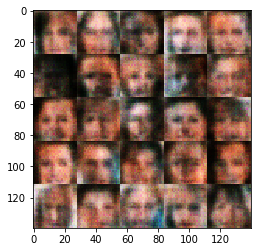

Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 1.5809
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 0.4894
Epoch 1/2... Discriminator Loss: 1.2302... Generator Loss: 0.6185
Epoch 1/2... Discriminator Loss: 1.9024... Generator Loss: 0.2724
Epoch 1/2... Discriminator Loss: 2.0942... Generator Loss: 0.2081
Epoch 1/2... Discriminator Loss: 1.2573... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 0.8726
Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 1.2526
Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 1.4862


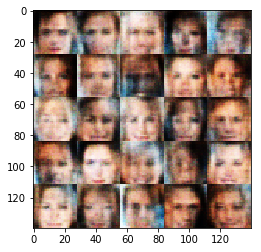

Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 0.5322
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 0.4889
Epoch 1/2... Discriminator Loss: 1.0245... Generator Loss: 0.8105
Epoch 1/2... Discriminator Loss: 1.4948... Generator Loss: 0.6746
Epoch 1/2... Discriminator Loss: 1.4730... Generator Loss: 0.5074
Epoch 1/2... Discriminator Loss: 1.0374... Generator Loss: 0.8926
Epoch 1/2... Discriminator Loss: 1.8549... Generator Loss: 0.2775
Epoch 1/2... Discriminator Loss: 0.8529... Generator Loss: 1.4567
Epoch 1/2... Discriminator Loss: 1.5971... Generator Loss: 0.4234
Epoch 1/2... Discriminator Loss: 2.3233... Generator Loss: 0.1619


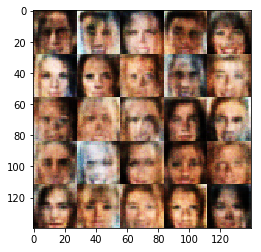

Epoch 1/2... Discriminator Loss: 1.2681... Generator Loss: 1.2009
Epoch 1/2... Discriminator Loss: 1.4372... Generator Loss: 0.5122
Epoch 1/2... Discriminator Loss: 0.7641... Generator Loss: 2.0822
Epoch 1/2... Discriminator Loss: 1.6052... Generator Loss: 1.3208
Epoch 1/2... Discriminator Loss: 1.2945... Generator Loss: 0.6656
Epoch 1/2... Discriminator Loss: 0.8170... Generator Loss: 1.4581
Epoch 1/2... Discriminator Loss: 1.4994... Generator Loss: 3.1471
Epoch 1/2... Discriminator Loss: 0.9408... Generator Loss: 1.1505
Epoch 1/2... Discriminator Loss: 1.3543... Generator Loss: 4.0137
Epoch 1/2... Discriminator Loss: 2.4410... Generator Loss: 3.2315


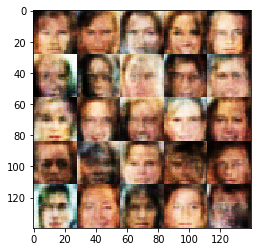

Epoch 1/2... Discriminator Loss: 1.5786... Generator Loss: 0.4097
Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 0.6975
Epoch 1/2... Discriminator Loss: 1.6515... Generator Loss: 0.3639
Epoch 1/2... Discriminator Loss: 0.9693... Generator Loss: 0.8875
Epoch 1/2... Discriminator Loss: 1.6040... Generator Loss: 0.3686
Epoch 1/2... Discriminator Loss: 0.8648... Generator Loss: 3.1202
Epoch 1/2... Discriminator Loss: 0.6339... Generator Loss: 2.1392
Epoch 1/2... Discriminator Loss: 1.5054... Generator Loss: 1.5172
Epoch 1/2... Discriminator Loss: 0.8925... Generator Loss: 1.4044
Epoch 1/2... Discriminator Loss: 0.5158... Generator Loss: 2.4590


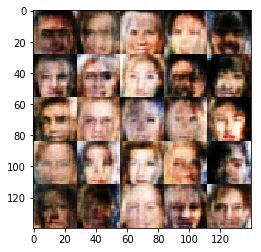

Epoch 1/2... Discriminator Loss: 0.6807... Generator Loss: 2.6253
Epoch 1/2... Discriminator Loss: 0.7016... Generator Loss: 1.4230
Epoch 1/2... Discriminator Loss: 1.0486... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 0.9793... Generator Loss: 3.4320
Epoch 1/2... Discriminator Loss: 0.6997... Generator Loss: 3.2043
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.4971
Epoch 1/2... Discriminator Loss: 0.7781... Generator Loss: 4.0801
Epoch 1/2... Discriminator Loss: 1.5848... Generator Loss: 0.4286
Epoch 1/2... Discriminator Loss: 1.1734... Generator Loss: 1.1062
Epoch 1/2... Discriminator Loss: 0.7847... Generator Loss: 1.2079


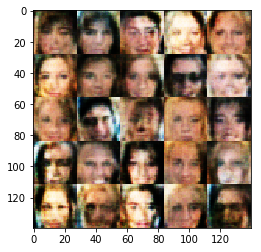

Epoch 1/2... Discriminator Loss: 0.7806... Generator Loss: 1.2979
Epoch 1/2... Discriminator Loss: 0.5347... Generator Loss: 3.5830
Epoch 1/2... Discriminator Loss: 0.4712... Generator Loss: 2.8334
Epoch 1/2... Discriminator Loss: 0.9144... Generator Loss: 4.5966
Epoch 1/2... Discriminator Loss: 0.4956... Generator Loss: 3.3883
Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 0.6808
Epoch 1/2... Discriminator Loss: 0.6944... Generator Loss: 2.7715
Epoch 1/2... Discriminator Loss: 0.5876... Generator Loss: 1.9500
Epoch 1/2... Discriminator Loss: 1.2398... Generator Loss: 0.6314
Epoch 1/2... Discriminator Loss: 0.8648... Generator Loss: 1.2018


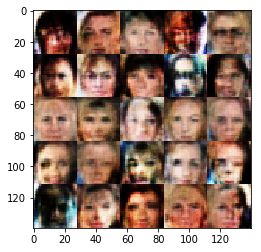

Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 0.6704
Epoch 1/2... Discriminator Loss: 0.5565... Generator Loss: 2.5677
Epoch 1/2... Discriminator Loss: 1.1689... Generator Loss: 0.7418
Epoch 1/2... Discriminator Loss: 0.4861... Generator Loss: 3.4971
Epoch 1/2... Discriminator Loss: 0.6689... Generator Loss: 1.6017
Epoch 1/2... Discriminator Loss: 0.7725... Generator Loss: 1.4772
Epoch 1/2... Discriminator Loss: 1.3178... Generator Loss: 0.5177
Epoch 1/2... Discriminator Loss: 1.1546... Generator Loss: 3.5437
Epoch 1/2... Discriminator Loss: 0.4592... Generator Loss: 2.8995
Epoch 1/2... Discriminator Loss: 0.4599... Generator Loss: 3.5781


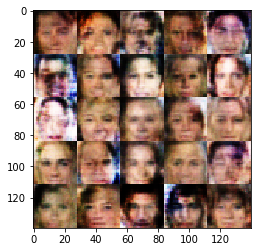

Epoch 1/2... Discriminator Loss: 0.7935... Generator Loss: 2.7292
Epoch 1/2... Discriminator Loss: 0.7272... Generator Loss: 1.3772
Epoch 1/2... Discriminator Loss: 0.7753... Generator Loss: 4.0617
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 3.9201
Epoch 1/2... Discriminator Loss: 0.4398... Generator Loss: 3.6298
Epoch 1/2... Discriminator Loss: 0.4965... Generator Loss: 4.2368
Epoch 1/2... Discriminator Loss: 0.5585... Generator Loss: 2.0956
Epoch 1/2... Discriminator Loss: 0.4552... Generator Loss: 3.7840
Epoch 1/2... Discriminator Loss: 0.5525... Generator Loss: 6.2952
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 1.2170


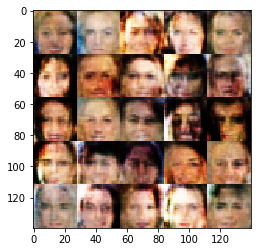

Epoch 1/2... Discriminator Loss: 0.6630... Generator Loss: 1.9750
Epoch 1/2... Discriminator Loss: 0.7460... Generator Loss: 3.7672
Epoch 1/2... Discriminator Loss: 0.5060... Generator Loss: 4.2839
Epoch 1/2... Discriminator Loss: 0.5280... Generator Loss: 4.4788
Epoch 1/2... Discriminator Loss: 0.4220... Generator Loss: 3.2937
Epoch 1/2... Discriminator Loss: 0.5988... Generator Loss: 3.9274
Epoch 1/2... Discriminator Loss: 0.4927... Generator Loss: 3.0509
Epoch 1/2... Discriminator Loss: 0.7376... Generator Loss: 1.2098
Epoch 1/2... Discriminator Loss: 0.6781... Generator Loss: 1.4948
Epoch 1/2... Discriminator Loss: 0.5135... Generator Loss: 2.8916


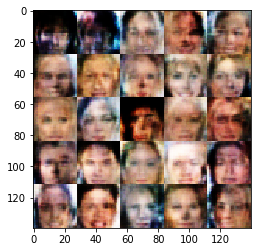

Epoch 1/2... Discriminator Loss: 0.8074... Generator Loss: 1.2650
Epoch 1/2... Discriminator Loss: 0.8826... Generator Loss: 1.0248
Epoch 1/2... Discriminator Loss: 0.4858... Generator Loss: 3.1135
Epoch 1/2... Discriminator Loss: 1.1213... Generator Loss: 4.8103
Epoch 1/2... Discriminator Loss: 0.5070... Generator Loss: 2.2287
Epoch 1/2... Discriminator Loss: 0.5647... Generator Loss: 2.1686
Epoch 1/2... Discriminator Loss: 0.7296... Generator Loss: 1.5450
Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 1.7037
Epoch 1/2... Discriminator Loss: 0.8009... Generator Loss: 5.7030
Epoch 1/2... Discriminator Loss: 0.5117... Generator Loss: 4.0084


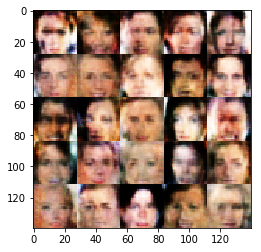

Epoch 1/2... Discriminator Loss: 0.5476... Generator Loss: 2.7752
Epoch 1/2... Discriminator Loss: 0.6727... Generator Loss: 1.6989
Epoch 1/2... Discriminator Loss: 0.5444... Generator Loss: 2.9482
Epoch 1/2... Discriminator Loss: 2.0719... Generator Loss: 3.5213
Epoch 1/2... Discriminator Loss: 0.7845... Generator Loss: 1.6143
Epoch 1/2... Discriminator Loss: 0.5448... Generator Loss: 2.1766
Epoch 1/2... Discriminator Loss: 0.6188... Generator Loss: 2.9587
Epoch 1/2... Discriminator Loss: 0.8473... Generator Loss: 1.0947
Epoch 1/2... Discriminator Loss: 0.5612... Generator Loss: 2.8592
Epoch 1/2... Discriminator Loss: 0.7258... Generator Loss: 1.4323


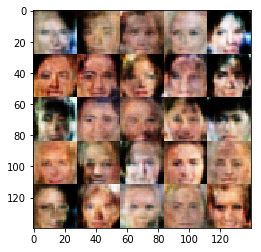

Epoch 1/2... Discriminator Loss: 0.6826... Generator Loss: 2.1266
Epoch 1/2... Discriminator Loss: 2.5124... Generator Loss: 2.6704
Epoch 1/2... Discriminator Loss: 0.6807... Generator Loss: 2.0353
Epoch 1/2... Discriminator Loss: 0.5730... Generator Loss: 2.0412
Epoch 1/2... Discriminator Loss: 0.5405... Generator Loss: 2.4551
Epoch 1/2... Discriminator Loss: 1.4446... Generator Loss: 1.9032
Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 0.9146
Epoch 1/2... Discriminator Loss: 0.6618... Generator Loss: 1.8401
Epoch 1/2... Discriminator Loss: 2.3804... Generator Loss: 0.1832
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 1.1060


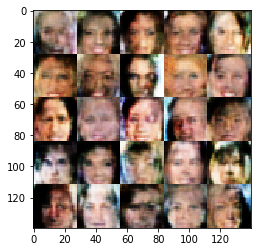

Epoch 1/2... Discriminator Loss: 0.6097... Generator Loss: 1.9585
Epoch 1/2... Discriminator Loss: 0.6666... Generator Loss: 2.3324
Epoch 1/2... Discriminator Loss: 0.5372... Generator Loss: 2.9981
Epoch 1/2... Discriminator Loss: 0.4703... Generator Loss: 4.4632
Epoch 1/2... Discriminator Loss: 0.5577... Generator Loss: 3.4751
Epoch 1/2... Discriminator Loss: 0.8218... Generator Loss: 3.7814
Epoch 1/2... Discriminator Loss: 1.7737... Generator Loss: 2.1336
Epoch 1/2... Discriminator Loss: 0.8120... Generator Loss: 3.0499
Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 2.6204
Epoch 1/2... Discriminator Loss: 0.7859... Generator Loss: 2.1246


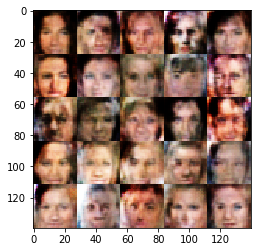

Epoch 1/2... Discriminator Loss: 1.5433... Generator Loss: 0.4398
Epoch 1/2... Discriminator Loss: 0.9847... Generator Loss: 0.9007
Epoch 1/2... Discriminator Loss: 0.5689... Generator Loss: 2.0299
Epoch 1/2... Discriminator Loss: 0.8041... Generator Loss: 1.3741
Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 3.0869
Epoch 1/2... Discriminator Loss: 0.7987... Generator Loss: 1.2337
Epoch 1/2... Discriminator Loss: 1.1709... Generator Loss: 0.8801
Epoch 1/2... Discriminator Loss: 0.6554... Generator Loss: 1.6287
Epoch 1/2... Discriminator Loss: 0.9315... Generator Loss: 2.7492
Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 2.1827


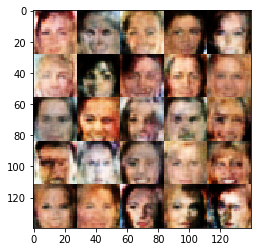

Epoch 1/2... Discriminator Loss: 0.7675... Generator Loss: 1.4684
Epoch 1/2... Discriminator Loss: 0.7377... Generator Loss: 1.6755
Epoch 1/2... Discriminator Loss: 1.0414... Generator Loss: 2.1361
Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 3.7320
Epoch 1/2... Discriminator Loss: 0.9135... Generator Loss: 1.2787
Epoch 1/2... Discriminator Loss: 0.8627... Generator Loss: 1.0851
Epoch 1/2... Discriminator Loss: 0.8165... Generator Loss: 1.2283
Epoch 1/2... Discriminator Loss: 0.6905... Generator Loss: 1.6760
Epoch 1/2... Discriminator Loss: 0.5940... Generator Loss: 2.3082
Epoch 1/2... Discriminator Loss: 0.7316... Generator Loss: 1.5232


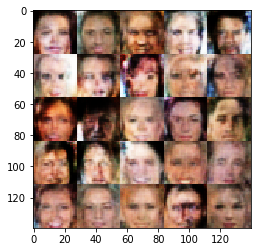

Epoch 1/2... Discriminator Loss: 0.5453... Generator Loss: 2.1713
Epoch 1/2... Discriminator Loss: 0.5461... Generator Loss: 2.9362
Epoch 1/2... Discriminator Loss: 0.5031... Generator Loss: 3.0524
Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 2.3585
Epoch 1/2... Discriminator Loss: 2.1725... Generator Loss: 0.2963
Epoch 1/2... Discriminator Loss: 1.0191... Generator Loss: 1.4596
Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 1.7208
Epoch 1/2... Discriminator Loss: 0.8716... Generator Loss: 1.3580
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 1.9794
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 1.1870


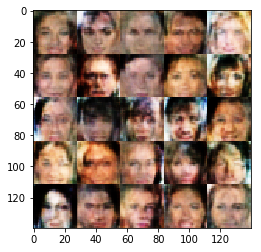

Epoch 1/2... Discriminator Loss: 0.6892... Generator Loss: 1.8251
Epoch 1/2... Discriminator Loss: 1.0986... Generator Loss: 1.7645
Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 0.9304
Epoch 1/2... Discriminator Loss: 0.6799... Generator Loss: 2.2670
Epoch 1/2... Discriminator Loss: 0.6119... Generator Loss: 2.3157
Epoch 1/2... Discriminator Loss: 0.6035... Generator Loss: 2.7267
Epoch 1/2... Discriminator Loss: 3.0608... Generator Loss: 3.0843
Epoch 1/2... Discriminator Loss: 1.4846... Generator Loss: 0.4584
Epoch 1/2... Discriminator Loss: 0.8565... Generator Loss: 1.4687
Epoch 1/2... Discriminator Loss: 0.7003... Generator Loss: 1.7929


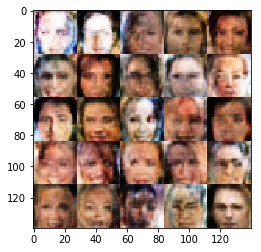

Epoch 1/2... Discriminator Loss: 0.9288... Generator Loss: 1.4197
Epoch 1/2... Discriminator Loss: 0.5326... Generator Loss: 2.3260
Epoch 1/2... Discriminator Loss: 0.7394... Generator Loss: 1.6926
Epoch 1/2... Discriminator Loss: 0.7883... Generator Loss: 1.4246
Epoch 1/2... Discriminator Loss: 2.6498... Generator Loss: 0.1353
Epoch 1/2... Discriminator Loss: 0.7527... Generator Loss: 1.6347
Epoch 1/2... Discriminator Loss: 0.8573... Generator Loss: 1.2028
Epoch 1/2... Discriminator Loss: 1.1195... Generator Loss: 0.7868
Epoch 1/2... Discriminator Loss: 0.8161... Generator Loss: 1.4220
Epoch 1/2... Discriminator Loss: 0.8646... Generator Loss: 1.3774


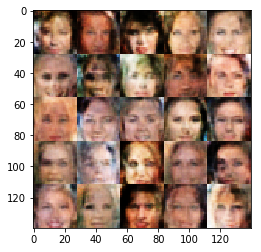

Epoch 1/2... Discriminator Loss: 0.8978... Generator Loss: 1.7967
Epoch 1/2... Discriminator Loss: 1.7312... Generator Loss: 2.0569
Epoch 1/2... Discriminator Loss: 0.8107... Generator Loss: 1.4477
Epoch 1/2... Discriminator Loss: 0.9254... Generator Loss: 1.3053
Epoch 1/2... Discriminator Loss: 1.0875... Generator Loss: 1.0794
Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 1.1600
Epoch 1/2... Discriminator Loss: 1.5057... Generator Loss: 0.5646
Epoch 1/2... Discriminator Loss: 0.8203... Generator Loss: 1.5545
Epoch 1/2... Discriminator Loss: 0.8080... Generator Loss: 1.2971
Epoch 1/2... Discriminator Loss: 1.8367... Generator Loss: 0.3521


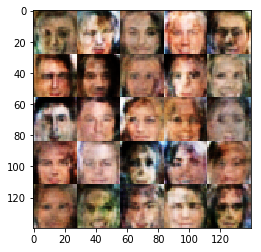

Epoch 1/2... Discriminator Loss: 0.9478... Generator Loss: 1.0152
Epoch 1/2... Discriminator Loss: 0.9341... Generator Loss: 1.3418
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 1.3439
Epoch 1/2... Discriminator Loss: 2.1331... Generator Loss: 2.4491
Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 0.9182
Epoch 1/2... Discriminator Loss: 0.8694... Generator Loss: 1.2915
Epoch 1/2... Discriminator Loss: 0.7786... Generator Loss: 2.4672
Epoch 1/2... Discriminator Loss: 0.7813... Generator Loss: 1.3026
Epoch 1/2... Discriminator Loss: 1.2662... Generator Loss: 0.5987
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 1.1154


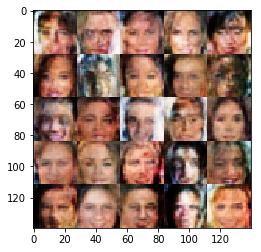

Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 0.7236
Epoch 1/2... Discriminator Loss: 0.7219... Generator Loss: 1.8313
Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 2.3170
Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 1.3143
Epoch 1/2... Discriminator Loss: 0.9522... Generator Loss: 1.1343
Epoch 1/2... Discriminator Loss: 0.9341... Generator Loss: 1.0083
Epoch 1/2... Discriminator Loss: 1.2300... Generator Loss: 0.6665
Epoch 1/2... Discriminator Loss: 1.0037... Generator Loss: 2.1729
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 1.3540
Epoch 1/2... Discriminator Loss: 1.0603... Generator Loss: 2.3502


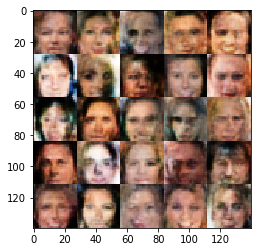

Epoch 1/2... Discriminator Loss: 1.0000... Generator Loss: 1.8794
Epoch 1/2... Discriminator Loss: 0.8162... Generator Loss: 2.0682
Epoch 1/2... Discriminator Loss: 0.7218... Generator Loss: 2.2007
Epoch 1/2... Discriminator Loss: 0.8789... Generator Loss: 1.1524
Epoch 1/2... Discriminator Loss: 0.8787... Generator Loss: 2.0503
Epoch 1/2... Discriminator Loss: 0.9591... Generator Loss: 0.9344
Epoch 1/2... Discriminator Loss: 2.5314... Generator Loss: 0.2238
Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 1.4522
Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 1.1911
Epoch 1/2... Discriminator Loss: 1.2513... Generator Loss: 0.6726


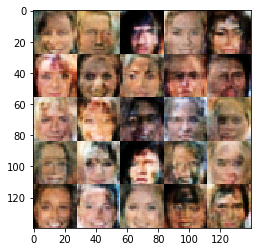

Epoch 1/2... Discriminator Loss: 1.1579... Generator Loss: 1.2408
Epoch 1/2... Discriminator Loss: 1.0860... Generator Loss: 1.0107
Epoch 1/2... Discriminator Loss: 0.8598... Generator Loss: 1.6361
Epoch 1/2... Discriminator Loss: 0.8831... Generator Loss: 2.0307
Epoch 1/2... Discriminator Loss: 1.5693... Generator Loss: 0.4330
Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 1.9436
Epoch 1/2... Discriminator Loss: 0.7767... Generator Loss: 1.4042
Epoch 1/2... Discriminator Loss: 0.9666... Generator Loss: 1.6968
Epoch 1/2... Discriminator Loss: 1.1917... Generator Loss: 0.6575
Epoch 1/2... Discriminator Loss: 1.3937... Generator Loss: 2.1604


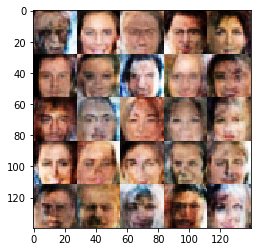

Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 2.2349
Epoch 1/2... Discriminator Loss: 0.9776... Generator Loss: 1.1125
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 0.8656
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.5032
Epoch 1/2... Discriminator Loss: 0.7677... Generator Loss: 1.3506
Epoch 1/2... Discriminator Loss: 1.0482... Generator Loss: 0.9555
Epoch 1/2... Discriminator Loss: 1.0272... Generator Loss: 0.9630
Epoch 1/2... Discriminator Loss: 1.2858... Generator Loss: 0.6368
Epoch 1/2... Discriminator Loss: 0.9083... Generator Loss: 1.0675
Epoch 1/2... Discriminator Loss: 2.0067... Generator Loss: 0.2620


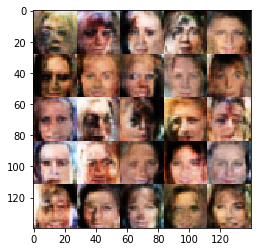

Epoch 1/2... Discriminator Loss: 0.8878... Generator Loss: 1.1596
Epoch 1/2... Discriminator Loss: 1.0444... Generator Loss: 0.9196
Epoch 1/2... Discriminator Loss: 0.9423... Generator Loss: 1.4127
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 1.3472
Epoch 1/2... Discriminator Loss: 1.0501... Generator Loss: 1.6996
Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 1.4799
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 0.7222
Epoch 1/2... Discriminator Loss: 0.7135... Generator Loss: 1.5848
Epoch 1/2... Discriminator Loss: 1.7651... Generator Loss: 2.4705
Epoch 1/2... Discriminator Loss: 1.0775... Generator Loss: 0.9172


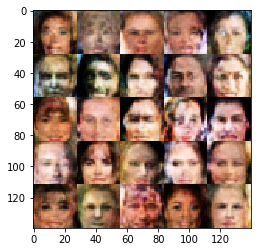

Epoch 1/2... Discriminator Loss: 0.9603... Generator Loss: 1.0342
Epoch 1/2... Discriminator Loss: 1.0515... Generator Loss: 1.9425
Epoch 1/2... Discriminator Loss: 1.4930... Generator Loss: 0.5046
Epoch 1/2... Discriminator Loss: 1.1174... Generator Loss: 0.7552
Epoch 1/2... Discriminator Loss: 0.9408... Generator Loss: 1.4507
Epoch 1/2... Discriminator Loss: 0.9566... Generator Loss: 1.1102
Epoch 1/2... Discriminator Loss: 0.9731... Generator Loss: 1.2442
Epoch 1/2... Discriminator Loss: 1.3965... Generator Loss: 2.0915
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 1.8640
Epoch 1/2... Discriminator Loss: 1.0207... Generator Loss: 0.8690


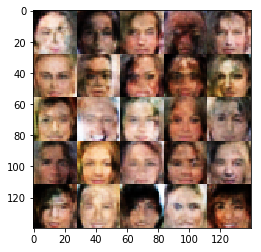

Epoch 1/2... Discriminator Loss: 0.8014... Generator Loss: 1.5996
Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 1.6299
Epoch 1/2... Discriminator Loss: 2.8851... Generator Loss: 3.6091
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.7361
Epoch 1/2... Discriminator Loss: 1.1879... Generator Loss: 0.7586
Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 0.7543
Epoch 1/2... Discriminator Loss: 0.8030... Generator Loss: 1.3269
Epoch 1/2... Discriminator Loss: 0.9452... Generator Loss: 0.9030
Epoch 1/2... Discriminator Loss: 1.1974... Generator Loss: 0.7154
Epoch 1/2... Discriminator Loss: 0.7520... Generator Loss: 1.9548


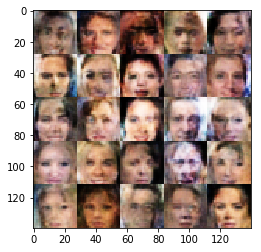

Epoch 1/2... Discriminator Loss: 0.8765... Generator Loss: 1.0775
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 1.7037
Epoch 1/2... Discriminator Loss: 0.8910... Generator Loss: 1.6389
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 1.6000
Epoch 1/2... Discriminator Loss: 0.7203... Generator Loss: 1.6425
Epoch 1/2... Discriminator Loss: 0.8495... Generator Loss: 2.0544
Epoch 1/2... Discriminator Loss: 0.6977... Generator Loss: 2.7409
Epoch 1/2... Discriminator Loss: 1.0330... Generator Loss: 1.1461
Epoch 1/2... Discriminator Loss: 1.8960... Generator Loss: 1.8747
Epoch 1/2... Discriminator Loss: 1.2608... Generator Loss: 0.6409


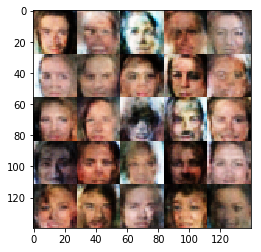

Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 1.0733
Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 0.9503
Epoch 1/2... Discriminator Loss: 0.6946... Generator Loss: 2.2127
Epoch 1/2... Discriminator Loss: 0.8550... Generator Loss: 1.3193
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 0.9308
Epoch 1/2... Discriminator Loss: 1.1306... Generator Loss: 0.7205
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 0.8603
Epoch 1/2... Discriminator Loss: 0.9680... Generator Loss: 1.1390
Epoch 1/2... Discriminator Loss: 0.8043... Generator Loss: 2.0165
Epoch 1/2... Discriminator Loss: 1.4755... Generator Loss: 1.5502


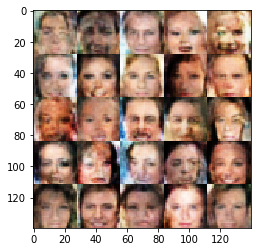

Epoch 1/2... Discriminator Loss: 0.8674... Generator Loss: 2.0121
Epoch 1/2... Discriminator Loss: 0.8080... Generator Loss: 1.7707
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 0.7403
Epoch 1/2... Discriminator Loss: 0.9789... Generator Loss: 0.9674
Epoch 1/2... Discriminator Loss: 0.7660... Generator Loss: 1.7605
Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 1.4626
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 1.5060
Epoch 1/2... Discriminator Loss: 1.0661... Generator Loss: 0.8142
Epoch 1/2... Discriminator Loss: 1.4019... Generator Loss: 0.4725
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 0.5230


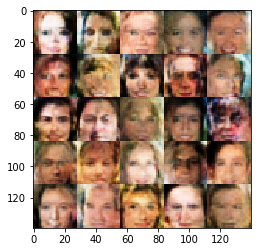

Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 0.6468
Epoch 1/2... Discriminator Loss: 0.9076... Generator Loss: 1.6075
Epoch 1/2... Discriminator Loss: 1.3107... Generator Loss: 1.4722
Epoch 1/2... Discriminator Loss: 1.0262... Generator Loss: 1.1374
Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 1.1890
Epoch 1/2... Discriminator Loss: 0.9648... Generator Loss: 1.0661
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.1112
Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 1.8300
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 1.2550
Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 1.3956


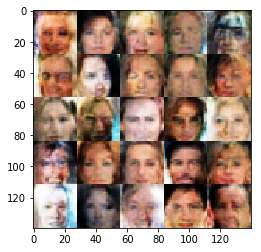

Epoch 1/2... Discriminator Loss: 0.9031... Generator Loss: 1.7224
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.5456
Epoch 1/2... Discriminator Loss: 1.3944... Generator Loss: 0.5513
Epoch 1/2... Discriminator Loss: 0.9472... Generator Loss: 1.0973
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 0.8863
Epoch 1/2... Discriminator Loss: 1.0039... Generator Loss: 0.9773
Epoch 1/2... Discriminator Loss: 1.0670... Generator Loss: 1.5711
Epoch 1/2... Discriminator Loss: 0.9078... Generator Loss: 1.0605
Epoch 1/2... Discriminator Loss: 0.9032... Generator Loss: 1.4255
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 1.5623


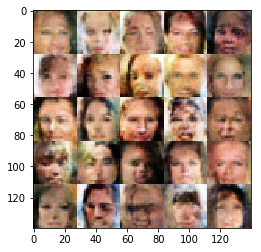

Epoch 1/2... Discriminator Loss: 1.8963... Generator Loss: 0.3054
Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 0.6554
Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 0.9035
Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 1.8314
Epoch 1/2... Discriminator Loss: 1.1552... Generator Loss: 0.6706
Epoch 1/2... Discriminator Loss: 1.0282... Generator Loss: 1.5050
Epoch 1/2... Discriminator Loss: 2.3281... Generator Loss: 0.2198
Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 1.7977
Epoch 1/2... Discriminator Loss: 0.9260... Generator Loss: 1.3181
Epoch 1/2... Discriminator Loss: 1.0217... Generator Loss: 0.9796


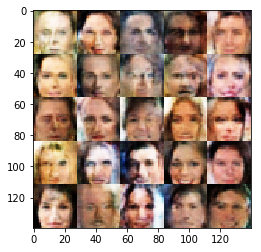

Epoch 1/2... Discriminator Loss: 0.9671... Generator Loss: 1.0426
Epoch 1/2... Discriminator Loss: 1.0636... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 0.6700
Epoch 1/2... Discriminator Loss: 0.8591... Generator Loss: 1.2006
Epoch 1/2... Discriminator Loss: 1.0291... Generator Loss: 1.0658
Epoch 1/2... Discriminator Loss: 1.0359... Generator Loss: 1.5938
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 1.0106
Epoch 1/2... Discriminator Loss: 1.5030... Generator Loss: 0.4414
Epoch 1/2... Discriminator Loss: 0.7445... Generator Loss: 1.7946
Epoch 1/2... Discriminator Loss: 1.3198... Generator Loss: 0.5490


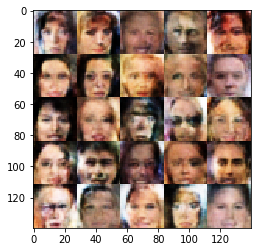

Epoch 1/2... Discriminator Loss: 1.4329... Generator Loss: 0.5135
Epoch 1/2... Discriminator Loss: 0.9182... Generator Loss: 1.0497
Epoch 1/2... Discriminator Loss: 1.6383... Generator Loss: 1.6455
Epoch 1/2... Discriminator Loss: 0.9817... Generator Loss: 1.1993
Epoch 1/2... Discriminator Loss: 0.9444... Generator Loss: 1.8116
Epoch 1/2... Discriminator Loss: 0.8647... Generator Loss: 1.5759
Epoch 1/2... Discriminator Loss: 0.8920... Generator Loss: 1.7895
Epoch 1/2... Discriminator Loss: 1.0704... Generator Loss: 1.0135
Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 1.2645
Epoch 1/2... Discriminator Loss: 1.7333... Generator Loss: 0.3219


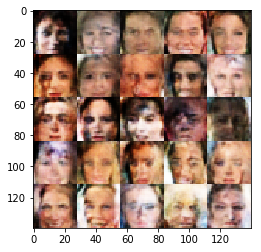

Epoch 1/2... Discriminator Loss: 0.9877... Generator Loss: 0.9721
Epoch 1/2... Discriminator Loss: 1.0271... Generator Loss: 0.9610
Epoch 1/2... Discriminator Loss: 0.8452... Generator Loss: 1.7715
Epoch 1/2... Discriminator Loss: 1.0098... Generator Loss: 1.3732
Epoch 1/2... Discriminator Loss: 1.4013... Generator Loss: 2.6893
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 1.0687
Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 1.1188
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 1.0189
Epoch 1/2... Discriminator Loss: 0.9463... Generator Loss: 1.5214
Epoch 1/2... Discriminator Loss: 1.0722... Generator Loss: 1.0859


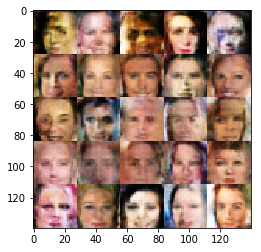

Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 0.8649
Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.5323
Epoch 1/2... Discriminator Loss: 0.8527... Generator Loss: 1.2529
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 0.8167
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 0.7613
Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 1.0248
Epoch 1/2... Discriminator Loss: 1.0183... Generator Loss: 1.2554
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 0.9745
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 1.1770
Epoch 1/2... Discriminator Loss: 0.8421... Generator Loss: 1.3319


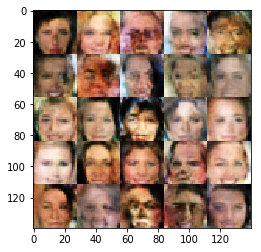

Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 1.5600
Epoch 1/2... Discriminator Loss: 1.1471... Generator Loss: 2.0805
Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 0.7922
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 1.2052
Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 0.7113
Epoch 1/2... Discriminator Loss: 0.9069... Generator Loss: 1.9307
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 1.3124
Epoch 1/2... Discriminator Loss: 0.8294... Generator Loss: 2.1338
Epoch 1/2... Discriminator Loss: 1.4963... Generator Loss: 1.6269
Epoch 1/2... Discriminator Loss: 1.4224... Generator Loss: 1.1665


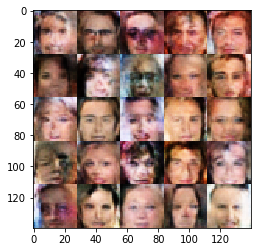

Epoch 1/2... Discriminator Loss: 1.0609... Generator Loss: 0.7911
Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 1.2823
Epoch 1/2... Discriminator Loss: 1.1874... Generator Loss: 2.0129
Epoch 1/2... Discriminator Loss: 0.9570... Generator Loss: 0.9424
Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 0.5272
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 0.6234
Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 0.8056
Epoch 1/2... Discriminator Loss: 0.8508... Generator Loss: 1.7522
Epoch 1/2... Discriminator Loss: 0.9110... Generator Loss: 1.4844
Epoch 1/2... Discriminator Loss: 1.1153... Generator Loss: 1.5252


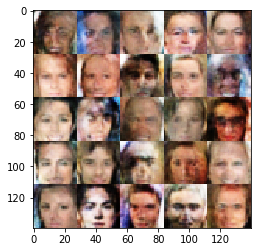

Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 1.2462
Epoch 1/2... Discriminator Loss: 1.1165... Generator Loss: 0.7709
Epoch 1/2... Discriminator Loss: 1.0442... Generator Loss: 1.1810
Epoch 1/2... Discriminator Loss: 0.7519... Generator Loss: 1.6425
Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 0.5352
Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 0.5581
Epoch 1/2... Discriminator Loss: 0.8647... Generator Loss: 1.5075
Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 2.4738
Epoch 1/2... Discriminator Loss: 1.1123... Generator Loss: 0.9659
Epoch 1/2... Discriminator Loss: 1.5542... Generator Loss: 0.4681


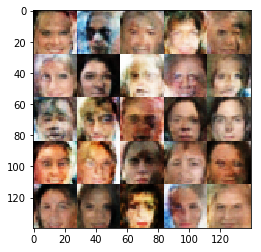

Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 1.2584
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.6430
Epoch 1/2... Discriminator Loss: 1.0167... Generator Loss: 1.0287
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 0.8472
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 1.2801
Epoch 1/2... Discriminator Loss: 0.9652... Generator Loss: 1.2229
Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 0.7134
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 1.3329
Epoch 1/2... Discriminator Loss: 0.7620... Generator Loss: 1.6078
Epoch 1/2... Discriminator Loss: 1.0509... Generator Loss: 0.8655


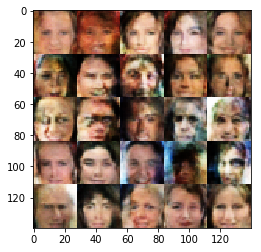

Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 1.4461
Epoch 1/2... Discriminator Loss: 0.7754... Generator Loss: 1.2911
Epoch 1/2... Discriminator Loss: 1.5343... Generator Loss: 0.4193
Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 0.7512
Epoch 1/2... Discriminator Loss: 1.3697... Generator Loss: 0.5125
Epoch 1/2... Discriminator Loss: 0.7158... Generator Loss: 2.3979
Epoch 1/2... Discriminator Loss: 0.8782... Generator Loss: 1.6441
Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 1.1317
Epoch 1/2... Discriminator Loss: 0.9680... Generator Loss: 1.3709
Epoch 1/2... Discriminator Loss: 0.7573... Generator Loss: 1.3981


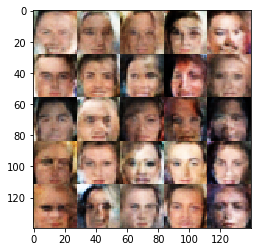

Epoch 1/2... Discriminator Loss: 0.9550... Generator Loss: 1.4172
Epoch 1/2... Discriminator Loss: 3.4574... Generator Loss: 3.4804
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 0.8556
Epoch 1/2... Discriminator Loss: 0.5652... Generator Loss: 2.1742
Epoch 1/2... Discriminator Loss: 1.0448... Generator Loss: 1.0203
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 0.7589
Epoch 1/2... Discriminator Loss: 0.9591... Generator Loss: 1.2221
Epoch 1/2... Discriminator Loss: 1.2496... Generator Loss: 0.5876
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.5823


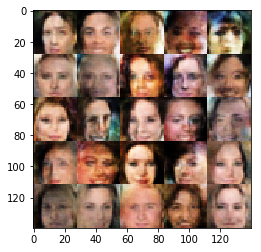

Epoch 1/2... Discriminator Loss: 0.9202... Generator Loss: 1.8234
Epoch 1/2... Discriminator Loss: 0.8230... Generator Loss: 1.3121
Epoch 1/2... Discriminator Loss: 0.9338... Generator Loss: 0.9903
Epoch 1/2... Discriminator Loss: 0.7458... Generator Loss: 1.7863
Epoch 1/2... Discriminator Loss: 0.9846... Generator Loss: 0.9230
Epoch 1/2... Discriminator Loss: 0.9445... Generator Loss: 1.0089
Epoch 1/2... Discriminator Loss: 1.3526... Generator Loss: 0.5556
Epoch 1/2... Discriminator Loss: 0.7120... Generator Loss: 1.5048
Epoch 1/2... Discriminator Loss: 2.7459... Generator Loss: 0.1574
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.5471


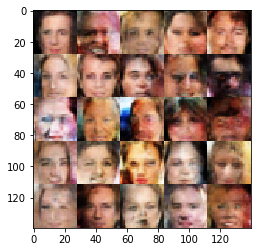

Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 0.9608... Generator Loss: 1.1590
Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 0.6569
Epoch 1/2... Discriminator Loss: 0.9042... Generator Loss: 1.0353
Epoch 1/2... Discriminator Loss: 0.7453... Generator Loss: 1.4062
Epoch 1/2... Discriminator Loss: 1.1668... Generator Loss: 0.7507
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 1.2658
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 0.6774
Epoch 1/2... Discriminator Loss: 1.0231... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 0.8443... Generator Loss: 1.5210


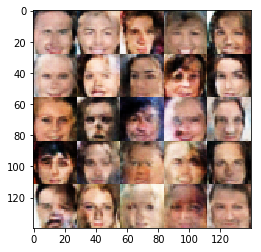

Epoch 1/2... Discriminator Loss: 1.5214... Generator Loss: 0.4151
Epoch 1/2... Discriminator Loss: 0.9309... Generator Loss: 1.0314
Epoch 1/2... Discriminator Loss: 1.0222... Generator Loss: 2.3227
Epoch 1/2... Discriminator Loss: 0.9254... Generator Loss: 1.3512
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 0.6615
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 1.5755
Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 1.2616
Epoch 1/2... Discriminator Loss: 1.0089... Generator Loss: 0.9644
Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 1.4894
Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 0.9091


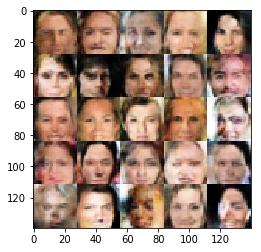

Epoch 1/2... Discriminator Loss: 0.9400... Generator Loss: 1.0402
Epoch 1/2... Discriminator Loss: 1.5550... Generator Loss: 2.2540
Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 0.9811
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 1.0734
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 0.8470
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 2.5627
Epoch 1/2... Discriminator Loss: 1.2041... Generator Loss: 1.4657
Epoch 1/2... Discriminator Loss: 1.1484... Generator Loss: 0.9190
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.0411
Epoch 1/2... Discriminator Loss: 1.0261... Generator Loss: 0.9153


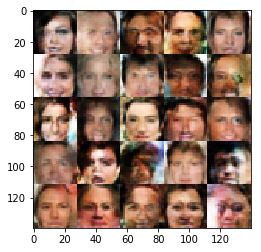

Epoch 1/2... Discriminator Loss: 0.9496... Generator Loss: 1.0558
Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 0.9189
Epoch 1/2... Discriminator Loss: 1.6645... Generator Loss: 2.6401
Epoch 1/2... Discriminator Loss: 1.0642... Generator Loss: 0.9012
Epoch 1/2... Discriminator Loss: 0.8420... Generator Loss: 2.1008
Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.5755
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 0.6624
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 0.9533... Generator Loss: 1.2410
Epoch 1/2... Discriminator Loss: 1.1098... Generator Loss: 0.7912


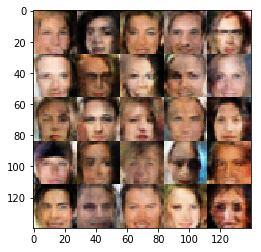

Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 1.4215
Epoch 1/2... Discriminator Loss: 0.9468... Generator Loss: 1.0453
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 1.2358
Epoch 1/2... Discriminator Loss: 0.7433... Generator Loss: 1.2729
Epoch 1/2... Discriminator Loss: 0.8080... Generator Loss: 1.8024
Epoch 1/2... Discriminator Loss: 1.0017... Generator Loss: 2.6080
Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 1.5604
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 1.2753... Generator Loss: 0.6279
Epoch 1/2... Discriminator Loss: 1.0499... Generator Loss: 1.0153


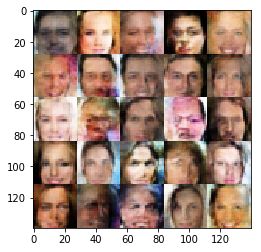

Epoch 1/2... Discriminator Loss: 0.9755... Generator Loss: 1.2147
Epoch 1/2... Discriminator Loss: 0.9331... Generator Loss: 1.1452
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 1.5845
Epoch 1/2... Discriminator Loss: 1.0090... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 1.0128... Generator Loss: 1.1548
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 0.9767
Epoch 1/2... Discriminator Loss: 1.0862... Generator Loss: 0.7933
Epoch 1/2... Discriminator Loss: 0.8595... Generator Loss: 1.1673
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.5113
Epoch 1/2... Discriminator Loss: 1.3260... Generator Loss: 1.5954


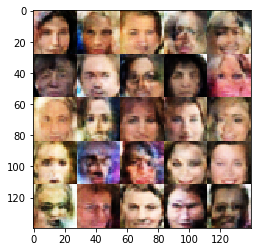

Epoch 1/2... Discriminator Loss: 1.3091... Generator Loss: 1.1584
Epoch 1/2... Discriminator Loss: 0.8723... Generator Loss: 1.4965
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 0.7477
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 1.1534
Epoch 1/2... Discriminator Loss: 1.0386... Generator Loss: 1.4350
Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 0.9679
Epoch 1/2... Discriminator Loss: 0.9954... Generator Loss: 0.8917
Epoch 1/2... Discriminator Loss: 0.6663... Generator Loss: 2.2267
Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 0.8642
Epoch 1/2... Discriminator Loss: 0.7281... Generator Loss: 2.0430


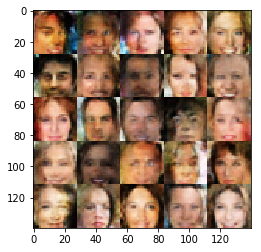

Epoch 1/2... Discriminator Loss: 0.9420... Generator Loss: 1.0091
Epoch 1/2... Discriminator Loss: 0.9646... Generator Loss: 0.9754
Epoch 1/2... Discriminator Loss: 1.0771... Generator Loss: 1.2756
Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 0.7566
Epoch 1/2... Discriminator Loss: 0.9210... Generator Loss: 1.4599
Epoch 1/2... Discriminator Loss: 1.1312... Generator Loss: 0.7312
Epoch 1/2... Discriminator Loss: 1.5446... Generator Loss: 0.4238
Epoch 1/2... Discriminator Loss: 1.1832... Generator Loss: 0.7627
Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 0.8295
Epoch 1/2... Discriminator Loss: 1.3985... Generator Loss: 0.5262


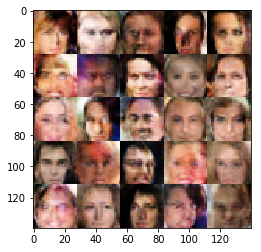

Epoch 1/2... Discriminator Loss: 0.9457... Generator Loss: 1.0882
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 1.5332
Epoch 1/2... Discriminator Loss: 1.4379... Generator Loss: 0.4525
Epoch 1/2... Discriminator Loss: 1.9593... Generator Loss: 0.2979
Epoch 1/2... Discriminator Loss: 1.4173... Generator Loss: 0.4926
Epoch 1/2... Discriminator Loss: 1.1145... Generator Loss: 0.9200
Epoch 1/2... Discriminator Loss: 0.9587... Generator Loss: 1.1427
Epoch 1/2... Discriminator Loss: 1.0511... Generator Loss: 1.2664
Epoch 1/2... Discriminator Loss: 0.9260... Generator Loss: 1.3864
Epoch 1/2... Discriminator Loss: 1.2563... Generator Loss: 0.5821


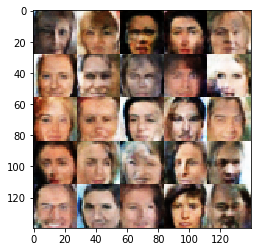

Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.4946
Epoch 1/2... Discriminator Loss: 1.0565... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 1.0566... Generator Loss: 1.3650
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 0.8484
Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 0.9471
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 1.3437
Epoch 1/2... Discriminator Loss: 1.1403... Generator Loss: 1.3362
Epoch 1/2... Discriminator Loss: 1.3412... Generator Loss: 0.5372
Epoch 1/2... Discriminator Loss: 1.3440... Generator Loss: 0.5205


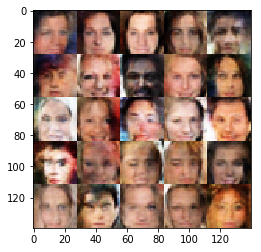

Epoch 1/2... Discriminator Loss: 1.2388... Generator Loss: 0.8248
Epoch 1/2... Discriminator Loss: 0.8954... Generator Loss: 1.7595
Epoch 1/2... Discriminator Loss: 0.8838... Generator Loss: 1.1592
Epoch 1/2... Discriminator Loss: 0.7700... Generator Loss: 2.2601
Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 0.5485
Epoch 1/2... Discriminator Loss: 1.3759... Generator Loss: 0.5715
Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 0.9267
Epoch 1/2... Discriminator Loss: 0.9253... Generator Loss: 0.9639
Epoch 1/2... Discriminator Loss: 0.9114... Generator Loss: 1.1983


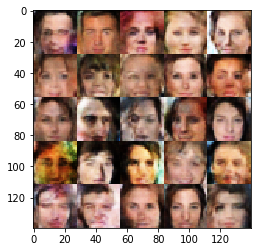

Epoch 1/2... Discriminator Loss: 0.8902... Generator Loss: 1.2315
Epoch 1/2... Discriminator Loss: 0.8308... Generator Loss: 2.0912
Epoch 1/2... Discriminator Loss: 3.8298... Generator Loss: 4.9027
Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 0.6285
Epoch 1/2... Discriminator Loss: 1.0113... Generator Loss: 1.7157
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 1.1302
Epoch 1/2... Discriminator Loss: 1.3200... Generator Loss: 0.5455
Epoch 1/2... Discriminator Loss: 1.3938... Generator Loss: 0.5793
Epoch 1/2... Discriminator Loss: 1.0188... Generator Loss: 0.9829
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 1.0711


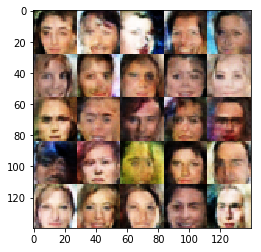

Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 0.6914
Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 0.9501
Epoch 1/2... Discriminator Loss: 0.9229... Generator Loss: 1.6684
Epoch 1/2... Discriminator Loss: 1.0785... Generator Loss: 0.8790
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.6543
Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 0.5505
Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 0.5860
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 1.0586... Generator Loss: 1.3280
Epoch 1/2... Discriminator Loss: 1.0258... Generator Loss: 1.2483


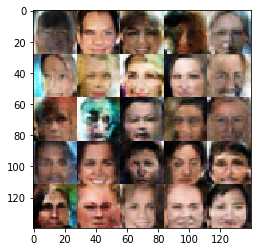

Epoch 1/2... Discriminator Loss: 0.9501... Generator Loss: 1.0296
Epoch 1/2... Discriminator Loss: 1.0822... Generator Loss: 0.9300
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 1.4000
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 1.7000
Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 0.9218
Epoch 1/2... Discriminator Loss: 1.4832... Generator Loss: 0.4465
Epoch 1/2... Discriminator Loss: 1.8486... Generator Loss: 0.2923
Epoch 1/2... Discriminator Loss: 1.1687... Generator Loss: 0.7092
Epoch 1/2... Discriminator Loss: 0.7536... Generator Loss: 1.4136
Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 0.8327


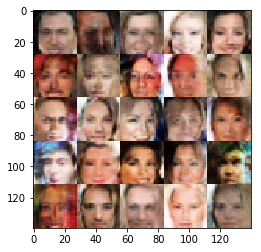

Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 0.8900
Epoch 1/2... Discriminator Loss: 1.0257... Generator Loss: 0.9718
Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 0.6287
Epoch 1/2... Discriminator Loss: 1.0797... Generator Loss: 1.9659
Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 1.0163
Epoch 1/2... Discriminator Loss: 0.8892... Generator Loss: 1.5166
Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 0.7127
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 1.3423
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 1.0316
Epoch 1/2... Discriminator Loss: 0.9655... Generator Loss: 0.9664


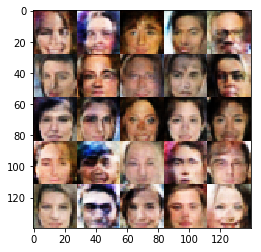

Epoch 1/2... Discriminator Loss: 1.2145... Generator Loss: 0.6817
Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 0.9107
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 1.6060
Epoch 1/2... Discriminator Loss: 1.6922... Generator Loss: 0.3934
Epoch 1/2... Discriminator Loss: 1.5767... Generator Loss: 0.4030
Epoch 1/2... Discriminator Loss: 0.9393... Generator Loss: 2.1597
Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 0.8753
Epoch 1/2... Discriminator Loss: 0.8604... Generator Loss: 1.2838
Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 0.7400
Epoch 1/2... Discriminator Loss: 2.2837... Generator Loss: 0.2104


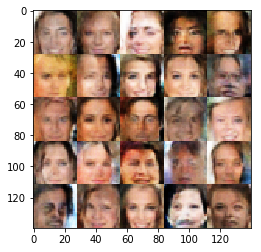

Epoch 1/2... Discriminator Loss: 0.9375... Generator Loss: 1.2981
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.5790
Epoch 1/2... Discriminator Loss: 1.1894... Generator Loss: 0.8549
Epoch 1/2... Discriminator Loss: 1.2237... Generator Loss: 0.6471
Epoch 1/2... Discriminator Loss: 1.2474... Generator Loss: 0.6414
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 0.4375
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 0.6136
Epoch 1/2... Discriminator Loss: 1.0713... Generator Loss: 0.8409
Epoch 1/2... Discriminator Loss: 0.9419... Generator Loss: 1.4645
Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 0.9112


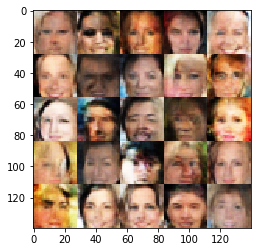

Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 0.6021
Epoch 1/2... Discriminator Loss: 2.0610... Generator Loss: 0.2295
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 0.9825
Epoch 2/2... Discriminator Loss: 1.1337... Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 1.0594... Generator Loss: 0.8823
Epoch 2/2... Discriminator Loss: 0.8580... Generator Loss: 1.2863
Epoch 2/2... Discriminator Loss: 1.0229... Generator Loss: 0.8646
Epoch 2/2... Discriminator Loss: 1.2931... Generator Loss: 0.5985
Epoch 2/2... Discriminator Loss: 1.7642... Generator Loss: 0.3708
Epoch 2/2... Discriminator Loss: 1.0642... Generator Loss: 0.8998


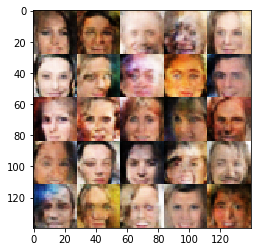

Epoch 2/2... Discriminator Loss: 0.8978... Generator Loss: 1.3248
Epoch 2/2... Discriminator Loss: 1.0126... Generator Loss: 1.2800
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 0.9844
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 0.8387
Epoch 2/2... Discriminator Loss: 1.1360... Generator Loss: 0.7866
Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 0.6199
Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 0.6294
Epoch 2/2... Discriminator Loss: 0.9983... Generator Loss: 1.7534
Epoch 2/2... Discriminator Loss: 1.3994... Generator Loss: 0.5294
Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 1.0867


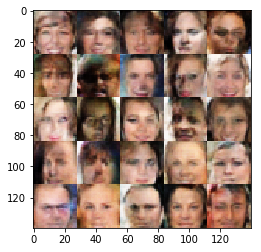

Epoch 2/2... Discriminator Loss: 0.9784... Generator Loss: 0.9087
Epoch 2/2... Discriminator Loss: 2.0106... Generator Loss: 0.2631


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.3



epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)